# Импорты библиотек

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as st
from datetime import datetime

# Чтение данных

In [2]:
df_path = "marketplace.csv"

df = pd.read_csv(df_path)
display(df.head())
df.info()

,user_id,platform_num,first_login,reg_dt,browser,first_buy,target,total_buy,total_return
0,user_000000,12,2025-03-22,2024-08-17,browser_00,2025-03-22,0.0,85.329559,0.0
1,user_000001,1,2025-05-05,2025-05-15,browser_01,2025-05-20,0.0,21.819124,0.0
2,user_000002,5,2025-01-19,2025-01-23,browser_02,2025-02-20,0.3,194.612980,485.0
3,user_000003,3,2025-03-15,2023-09-05,browser_02,NaN,0.0,138.780814,0.0
4,user_000004,1,2025-05-05,2025-05-14,browser_00,2025-05-11,0.0,16.334507,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25335 entries, 0 to 25334
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   user_id       25335 non-null  object 
 1   platform_num  25335 non-null  int64  
 2   first_login   25335 non-null  object 
 3   reg_dt        25331 non-null  object 
 4   browser       25335 non-null  object 
 5   first_buy     24361 non-null  object 
 6   target        25335 non-null  float64
 7   total_buy     25335 non-null  float64
 8   total_return  25335 non-null  float64
dtypes: float64(3), int64(1), object(5)
memory usage: 1.7+ MB


# Чистка данных

## Преобразование типов

In [3]:
df_cleaned = df.copy()

# df_cleaned = df_cleaned.astype({'reg_dt': int, 'first_buy': int, 'first_login': dt})

df_cleaned["reg_dt"] = pd.to_datetime(df_cleaned["reg_dt"], errors="coerce")
df_cleaned["first_buy"] = pd.to_datetime(df_cleaned["first_buy"], errors="coerce")
df_cleaned["first_login"] = pd.to_datetime(df_cleaned["first_login"], errors="coerce")

df_cleaned["user_id"] = df_cleaned["user_id"].apply(lambda x: int(x.strip("user_")))
df_cleaned["browser"] = df_cleaned["browser"].apply(lambda x: int(x.strip("browser_")))

In [4]:
df_cleaned["quote"] = df_cleaned["total_buy"]/(df_cleaned["total_return"] + df_cleaned["total_buy"])

## Заполнение нулей

In [5]:
df_cleaned["first_buy"].fillna(df_cleaned[['first_login', 'reg_dt']].max(axis=1), inplace=True)

## Склеивание дублей и индексация по user_id

In [6]:
df_cleaned = df_cleaned.groupby(by="user_id").agg(
    {
        "platform_num": "min",
        "first_login": "min",
        "reg_dt": "min",
        "browser": "min",
        "first_buy": "min",
        "target": "mean",
        "total_buy": "sum",
        "total_return": "sum",
    }
)
# df_cleaned.head()
# cmap="gist_ncar"

# plt.ylim(0, 100)
# plt.xticks(size=50)

### Вспомогательные методы

In [90]:
def shapiro_check(dataset, col, alpha=0.05, n=3000):
    """
    Шапиро. Тест, является ли распределение СВ нормальным
    """
    checked_dataset = dataset[col] if n is None else dataset[col].sample(n=n)
    stat, pvalue = st.shapiro(checked_dataset)
    print('Шапиро')
    if pvalue > alpha:
        print(f'Данные {col} скорее всего распределены нормально\n')
    else:
        print(f'Данные {col} скорее всего распределены не нормально\n')

def kstest_check(dataset, col, alpha=0.05):
    """
    Колмогоров-Смирнов. Тест, является ли распределение СВ нормальным
    """
    arr = dataset[col]
    mu = arr.mean()
    sigma = arr.std(ddof=1)
    stat, pvalue = st.kstest(arr, 'norm', args=(mu, sigma))

    print('Колмогоров-Смирнов')

    if pvalue > alpha:
        print(f'Данные {col} скорее всего распределены нормально\n')
    else:
        print(f'Данные {col} скорее всего распределены не нормально\n')

def iqr_filter(dataset, col):
    """
    Фильтр по межквартильному р
    """
    medi = dataset[col].median()
    Q1, Q3 = dataset[col].quantile([0.25, 0.75])
    IQR = Q3 - Q1

    bottom, top = medi - 1.5 * IQR, medi + 1.5 * IQR
    display(dataset[(dataset[col] < bottom) | (dataset[col] > top)])
    
    return dataset[(dataset[col] >= bottom) & (dataset[col] <= top)]

## Устраняем асинхронность в датах - дата первой покупки не должна быть меньше даты логина или регистрации

In [8]:
df_cleaned.loc[(df_cleaned['reg_dt'] > df_cleaned['first_buy']), ['reg_dt']] = df_cleaned['first_buy']
df_cleaned.loc[(df_cleaned['first_login'] > df_cleaned['first_buy']), ['first_login']] = df_cleaned['first_buy']

In [9]:
df_cleaned.head()

,platform_num,first_login,reg_dt,browser,first_buy,target,total_buy,total_return
user_id,,,,,,,,
0,12,2025-03-22,2024-08-17,0,2025-03-22,0.0,85.329559,0.0
1,1,2025-05-05,2025-05-15,1,2025-05-20,0.0,21.819124,0.0
2,5,2025-01-19,2025-01-23,2,2025-02-20,0.3,194.612980,485.0
3,3,2025-03-15,2023-09-05,2,2025-03-15,0.0,138.780814,0.0
4,1,2025-05-05,2025-05-11,0,2025-05-11,0.0,16.334507,0.0


## Убрать выбросы по межквартильному размаху

In [10]:
df_cleaned_iqr = pd.DataFrame(data=df_cleaned)
df_cleaned_iqr = iqr_filter(df_cleaned_iqr, "total_buy")

shapiro_check(df_cleaned_iqr, 'total_buy')
kstest_check(df_cleaned_iqr, 'total_buy')
shapiro_check(df_cleaned_iqr, 'total_return')
kstest_check(df_cleaned_iqr, 'total_return')

,platform_num,first_login,reg_dt,browser,first_buy,target,total_buy,total_return
user_id,,,,,,,,
5,7,2025-03-27,2024-06-06,2,2025-03-30,0.3,504.585202,0.0
12,6,2024-09-18,2024-07-04,1,2024-09-18,0.0,907.248037,0.0
13,11,2025-03-16,2023-07-03,2,2025-03-16,0.0,566.375842,0.0
18,9,2025-02-22,2025-03-03,6,2025-03-03,0.0,800.800483,0.0
30,5,2025-03-24,2024-12-19,8,2025-03-30,0.0,6516.049757,4830.0
...,...,...,...,...,...,...,...,...
25314,9,2024-11-02,2024-10-29,2,2024-11-02,0.0,1024.693218,0.0
25317,2,2025-04-27,2024-05-09,1,2025-05-02,0.0,1941.558041,200.0
25324,7,2025-03-23,2024-11-07,2,2025-03-23,0.0,1076.113379,570.0


Шапиро
Данные total_buy скорее всего распределены не нормально

Колмогоров-Смирнов
Данные total_buy скорее всего распределены не нормально

Шапиро
Данные total_return скорее всего распределены не нормально

Колмогоров-Смирнов
Данные total_return скорее всего распределены не нормально



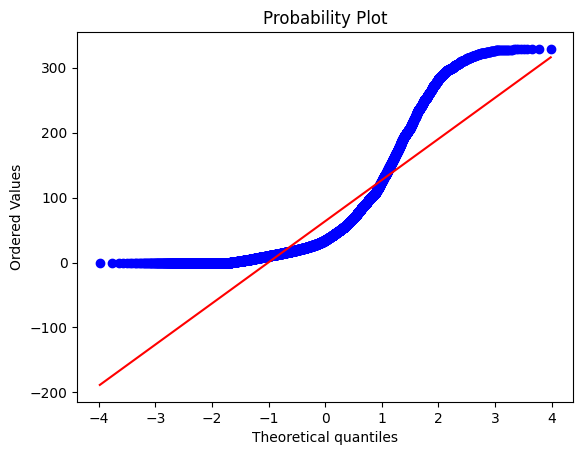

In [11]:
st.probplot(df_cleaned_iqr['total_buy'], plot=plt)

plt.show()

## Выводы

Данные распределены не нормально на уровне доверия 95%. При проверке гипотез будем использовать непараметрические тесты.

# Гипотезы

### Рассмотрим следующие гипотезы:
 1. Влияние заранее зарегистрировавшихся пользователей (задолго до первого логина/покупки) и пользователей, которые произвели покупку до регистрации Саша Р.
 2. Влияние браузера на прибыльность или на скорость покупки. Саша Г.
 3. Рассмотреть превалирирование определённого браузера/браузеров у юзеров, совершивших больше всего возвратов. Лиля
 4. Аномальные всплески покупок за весь период анализа. Антон
 5. Аномальные всплески возвратов за весь период анализа. Антон

Стратегия проверки: Формулируем каждую гипотезу в формате $H_0H_1$. В дальнейшем проверяем каждую гипотезу отдельно уровне доверия 95%.


### Гипотеза №1 "Консервы"
_Влияние заранее зарегистрировавшихся пользователей и пользователей, которые произвели покупку до регистрации_   

На выдвижение данной гипотезы меня натолкнула идея построения графиков зависимостей всех трёх дат (регистрация, первый логин, первая покупка) попарно, в поисках аномалий.

### Переформулируем гипотезу в формате H₀H₁:

H₀: У пользователей, заранее зарегистрировавшихся задолго до первого логина/покупки или совершивших покупку до регистрации, нет значимого отличия по среднему значению и дисперсиям по ключевым метрикам (количество покупок/возвратов, вероятность совершения покупки и т.д.) от пользователей с нормальной последовательностью событий (регистрация → логин → покупка).

H₁: У пользователей, заранее зарегистрировавшихся задолго до первого логина/покупки или совершивших покупку до регистрации, есть значимое отличие по среднему значению и дисперсиям по ключевым метрикам от пользователей с нормальной последовательностью событий.

In [12]:
# обогащу таблицу разницей времени между тремя событиями
df_enriched = df_cleaned_iqr.copy()

df_enriched["first_buy_reg_diff"] = (
    df_cleaned_iqr["first_buy"] - df_cleaned_iqr["reg_dt"]
).dt.days
df_enriched["first_login_buy_diff"] = (
    df_cleaned_iqr["first_login"] - df_cleaned_iqr["first_buy"]
).dt.days
df_enriched["first_login_reg_diff"] = (
    df_cleaned_iqr["first_login"] - df_cleaned_iqr["reg_dt"]
).dt.days
display(df_enriched.head(2))


,platform_num,first_login,reg_dt,browser,first_buy,target,total_buy,total_return,first_buy_reg_diff,first_login_buy_diff,first_login_reg_diff
user_id,,,,,,,,,,,
0,12,2025-03-22,2024-08-17,0,2025-03-22,0.0,85.329559,0.0,217,0,217
1,1,2025-05-05,2025-05-15,1,2025-05-20,0.0,21.819124,0.0,5,-15,-10


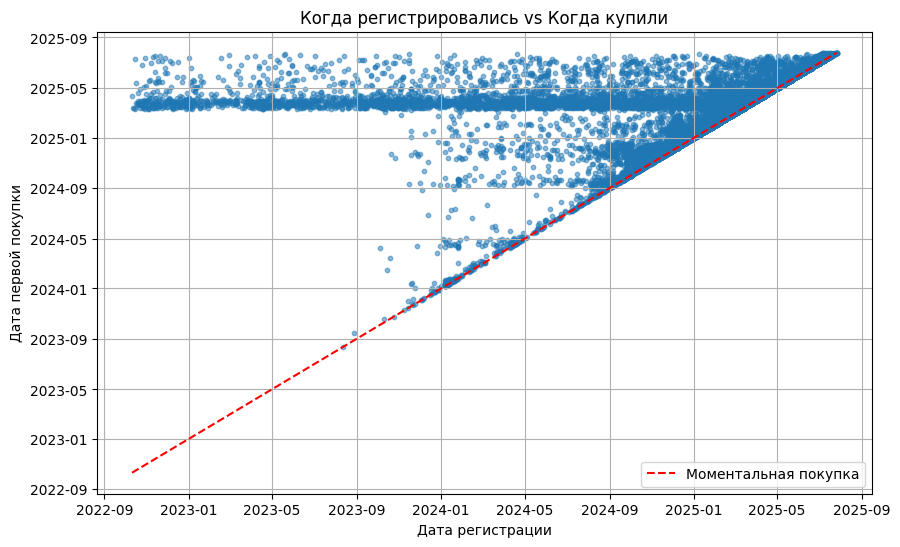

In [13]:
# Строим график зависимости дат регистрации и дат первой покупки
plt.figure(figsize=(10, 6))

# Рисуем точки
plt.scatter(df_enriched["reg_dt"], df_enriched["first_buy"], alpha=0.5, s=10)

# Добавляем линию "мгновенной покупки" (где X=Y), чтобы видеть задержку
# (для наглядности просто проведем диагональ)
min_date = df_enriched["reg_dt"].min()
max_date = df_enriched["first_buy"].max()
plt.plot(
    [min_date, max_date],
    [min_date, max_date],
    color="red",
    linestyle="--",
    label="Моментальная покупка",
)

plt.title("Когда регистрировались vs Когда купили")
plt.xlabel("Дата регистрации")
plt.ylabel("Дата первой покупки")
plt.legend()
plt.grid(True)
plt.show()


Видим аномальные отклонения от предсказуемой красной линии, есть объёмная группа юзеров, что регестрировались на протяжении всего периода, но покупки совершали в марте-апреле 2025. Это требует дополнительных исследований.

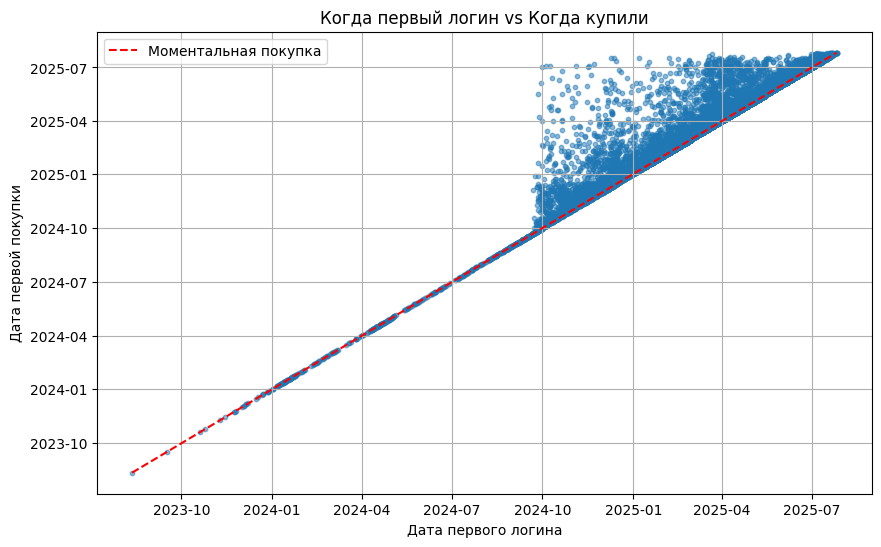

In [14]:
# Строим график зависимости дат первого логина и дат первой покупки
plt.figure(figsize=(10, 6))

# Рисуем точки
plt.scatter(df_enriched["first_login"], df_enriched["first_buy"], alpha=0.5, s=10)

# Добавляем линию "мгновенной покупки" (где X=Y), чтобы видеть задержку
# (для наглядности просто проведем диагональ)
min_date = df_enriched["first_login"].min()
max_date = df_enriched["first_buy"].max()
plt.plot(
    [min_date, max_date],
    [min_date, max_date],
    color="red",
    linestyle="--",
    label="Моментальная покупка",
)

plt.title("Когда первый логин vs Когда купили")
plt.xlabel("Дата первого логина")
plt.ylabel("Дата первой покупки")
plt.legend()
plt.grid(True)
plt.show()


Тут, предварительно, не выводится надёжной визуальной зависимости.

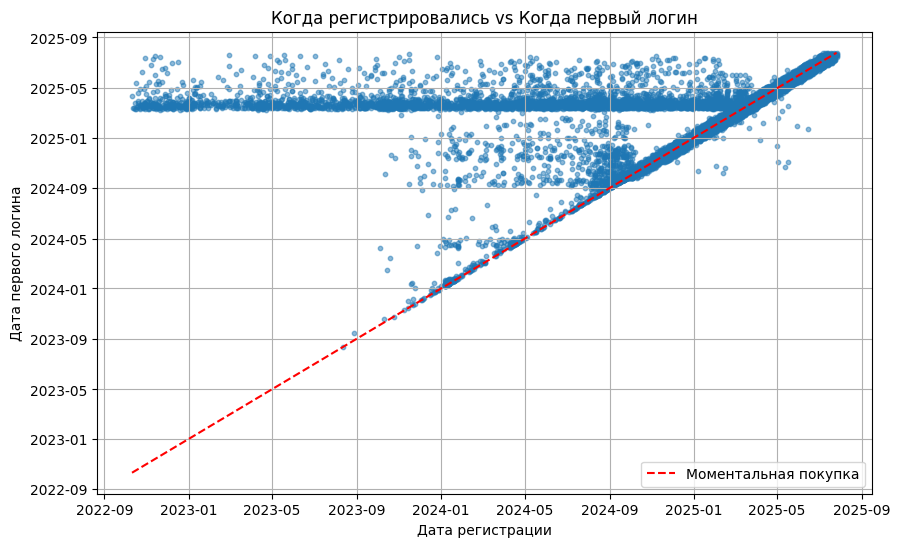

In [15]:
# Строим график зависимости дат регистрации и дат первого логина
plt.figure(figsize=(10, 6))

# Рисуем точки
plt.scatter(df_enriched["reg_dt"], df_enriched["first_login"], alpha=0.5, s=10)

# Добавляем линию "мгновенной покупки" (где X=Y), чтобы видеть задержку
# (для наглядности просто проведем диагональ)
min_date = df_enriched["reg_dt"].min()
max_date = df_enriched["first_login"].max()
plt.plot(
    [min_date, max_date],
    [min_date, max_date],
    color="red",
    linestyle="--",
    label="Моментальная покупка",
)

plt.title("Когда регистрировались vs Когда первый логин")
plt.xlabel("Дата регистрации")
plt.ylabel("Дата первого логина")
plt.legend()
plt.grid(True)
plt.show()


Видим аномалию, аналогичную первому графику, соответственно регистрация была давно, а первая покупка и логин (если это одни и те же пользователи) произведены в марте-апреле 2025.   
Также заметен дополнительный аномальный интервал к концу 2024 года, также требующий анализа.

### Гипотеза №2 "Прибыльные браузеры"
_Группируем покупки по браузерам, и рассчитываем прибыль:_
```sql
(SUM(total_buy) - SUM(total_return)) / COUNT(browser)
```

###Переформулируем гипотезу в формате H₀H₁:
H₀: Прибыль не зависит от типа браузера.

H₁: Прибыль зависит от типа браузера.

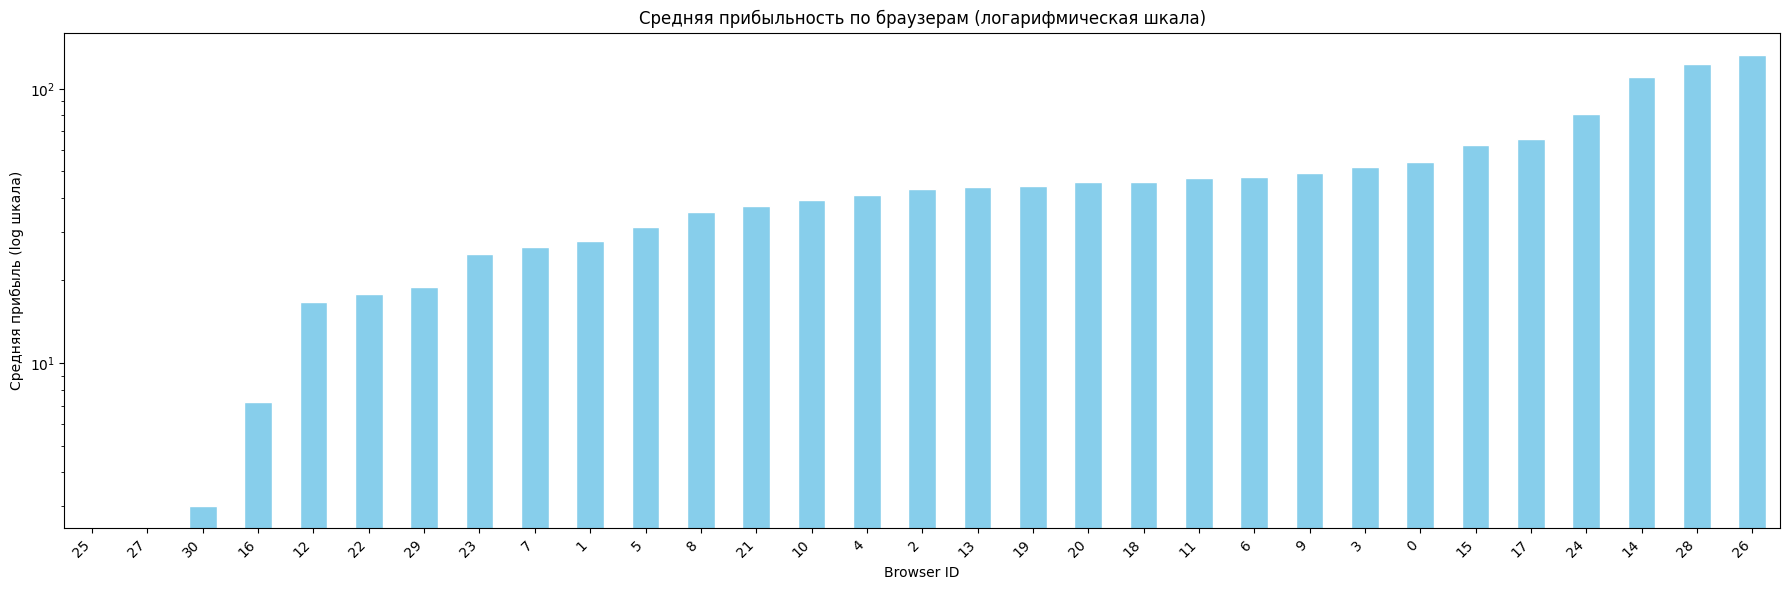

In [16]:
browser_profit = (
    df_enriched
    .groupby("browser")
    .agg(
        buy_sum=("total_buy", "sum"),
        return_sum=("total_return", "sum"),
        count=("browser", "count"),
    )
)

# Средняя прибыль на браузер
browser_profit["avg_profit"] = (browser_profit["buy_sum"] - browser_profit["return_sum"]) / browser_profit["count"]

# Сортировка по средней прибыли
browser_profit_sorted = browser_profit.sort_values("avg_profit", ascending=True)

plt.figure(figsize=(18, 6))

ax = browser_profit_sorted["avg_profit"].plot(
    kind="bar",
    color="skyblue",
    edgecolor="white",
)

plt.yscale("log")  # Логарифмическая шкала более очевидна из-за большой разницы между минимальной и максимальной прибыльностью

plt.title("Средняя прибыльность по браузерам (логарифмическая шкала)")
plt.xlabel("Browser ID")
plt.ylabel("Средняя прибыль (log шкала)")

plt.xticks(rotation=45, ha="right")

plt.tight_layout()
plt.show()

### Гипотеза №3 "Браузерные войны!"
_Предпочтения браузера у юзеров, совершивших больше всего покупок/возвратов._

Рассмотрим корреляцию используемых браузеров юзерами.

### Переформулируем гипотезу в формате $H_0H_1$:

$H_0$: Количество покупок не зависит от браузера.

$H_1$: Количество покупок зависит от браузера.

Построение нулевой и альтернативной гипотез.
● Выбор уровня значимости.
● Сбор данных для проверки гипотезы.
● Выбор статистического теста.
● Проведение статистического теста, вычисление p-value.
● Сравнение p-value c уровнем значимости и вывод,
отклонить или не отклонить нулевую гипотезу.

Алгоритм выбора критерия
Шаг 1: Какой тип переменной сравниваем?
1. Количественная (числовая)
Шаг 2: Сколько групп сравнивается?
● >2 групп.

Шаг 3: Группы зависимы или независимы?
● Независимые группы: сравниваются разные пользователи в одно и то же время.

Шаг 4: Есть ли нормальность распределения?
Для количественных переменных проверяем нормальность (например, с помощью теста Шапиро-Уилка или визуально).

Критерий Краскела-Уоллиса

In [321]:
df_browsers = df_enriched[["total_buy", "browser"]].groupby([df_enriched["first_buy"].dt.date, "browser"]).count()
display(df_browsers)
df_browsers = df_browsers.reset_index()
# df_browsers = df_browsers.loc[df_browsers["first_buy"] < datetime.strptime('2024-04-01', '%Y-%m-%d').date()]

def df_month(dataset, month):
    start_date = month.to_timestamp(how='start')
    end_date = month.to_timestamp(how='end')
    return dataset.loc[(df_browsers["first_buy"] >= start_date) & (df_browsers["first_buy"] < end_date)]

df_browsers["first_buy"] = pd.to_datetime(df_browsers["first_buy"], errors="coerce")

months_array = df_browsers['first_buy'].dt.to_period('M').unique()


total_buy
first_buy  browser           
2023-08-12 3                1
2023-09-16 1                1
2023-10-20 4                1
2023-10-25 1                1
2023-11-09 2                1
...                       ...
2025-07-25 3                3
2025-07-26 0                1
           1                1
           2                4
           3                2

[3262 rows x 1 columns]

In [322]:
def df_browsers_array(dataset):
    result = []
    for browser_n in dataset["browser"].unique():
        df_browsers_n = dataset.loc[dataset["browser"] == browser_n]
        df_browsers_n = df_browsers_n.reset_index(drop=True)
        if len(df_browsers_n["browser"].unique()) > 1:
            shapiro_check(df_browsers_n, 'total_buy', n=None)
            kstest_check(df_browsers, 'total_buy')
        result.append(df_browsers_n['total_buy'].values)
    return result

In [323]:
def statistic(args):
    h_statistic, p_value = st.kruskal(*args)
    result = "На уровне значимости 0.05 "
    if p_value < 0.05:
        result += "есть значимые различия между группами."
    else:
        result += "нет значимых различий между группами."
    return result

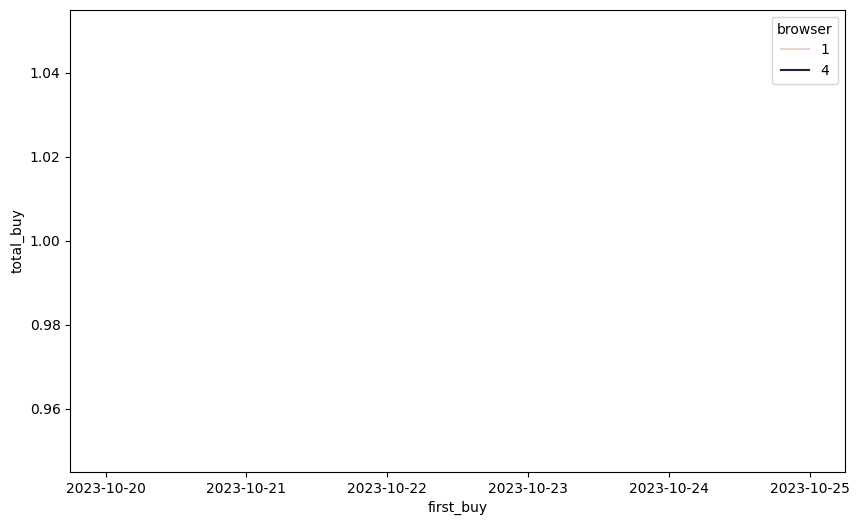

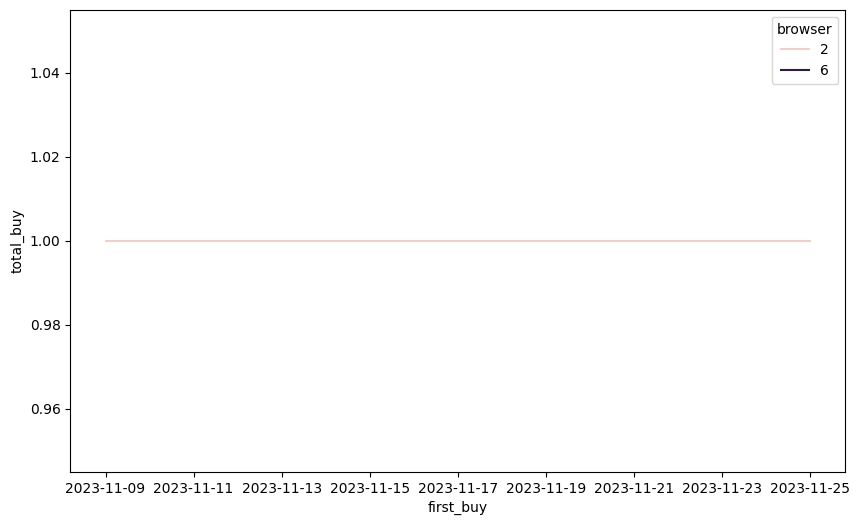

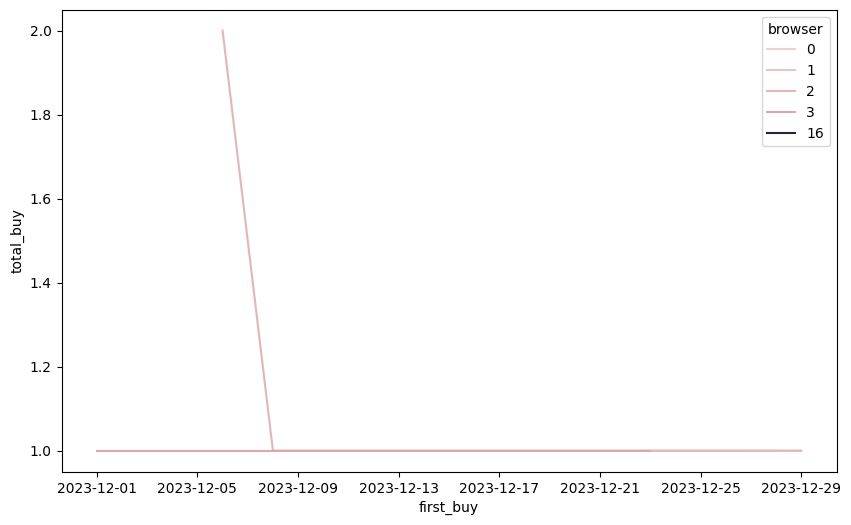

2023-12 - На уровне значимости 0.05 нет значимых различий между группами.


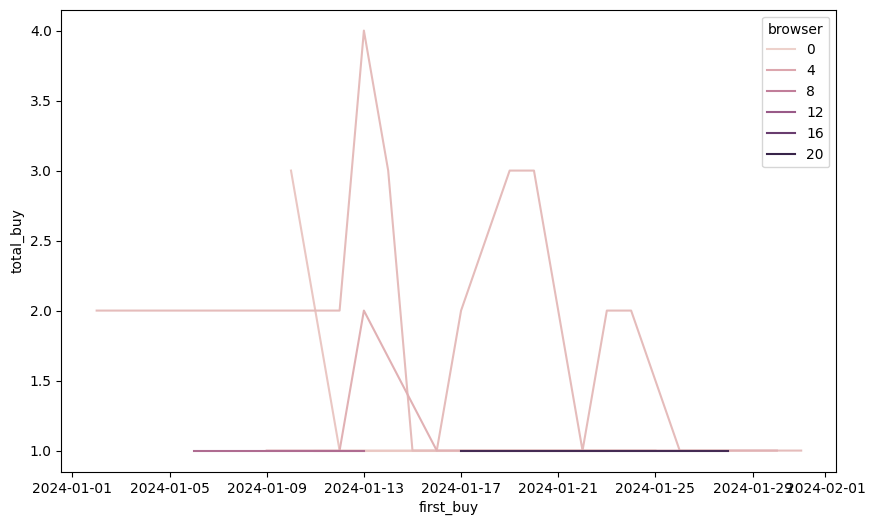

2024-01 - На уровне значимости 0.05 есть значимые различия между группами.


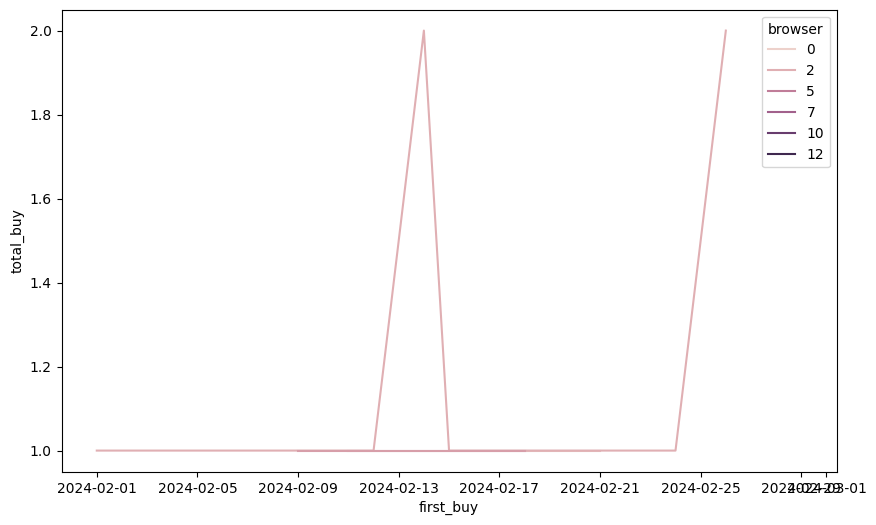

2024-02 - На уровне значимости 0.05 нет значимых различий между группами.


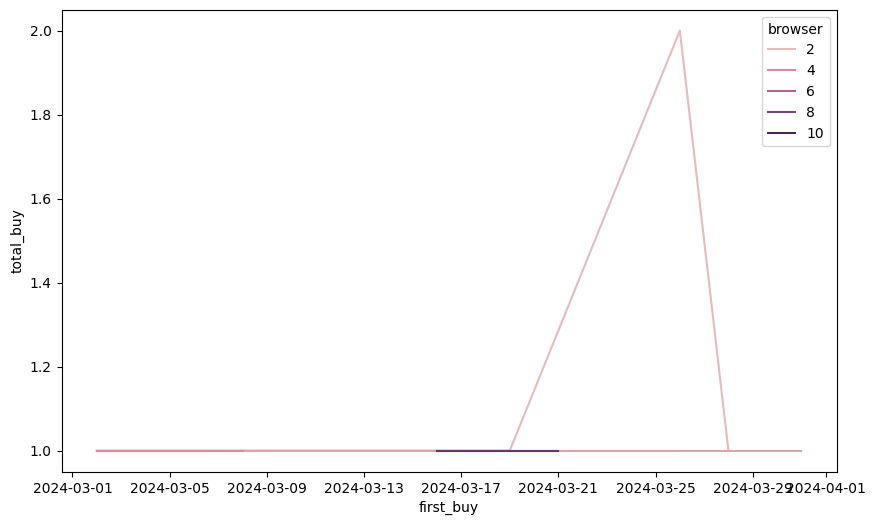

2024-03 - На уровне значимости 0.05 нет значимых различий между группами.


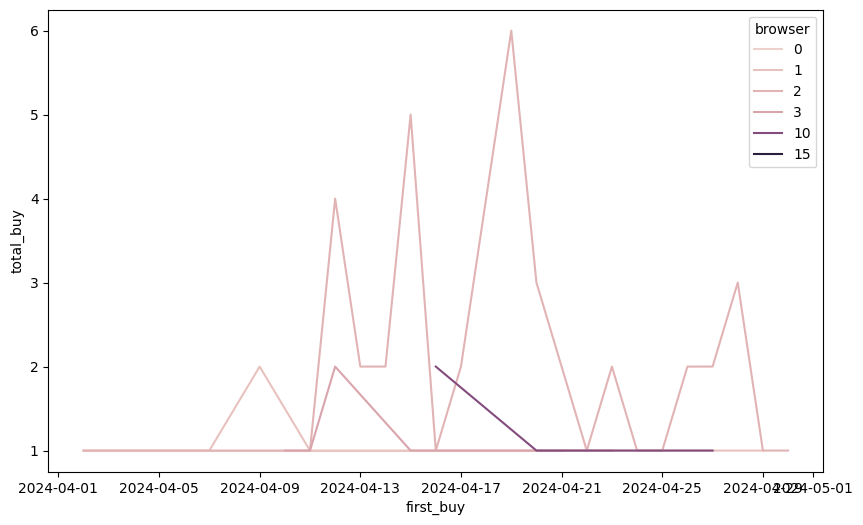

2024-04 - На уровне значимости 0.05 нет значимых различий между группами.


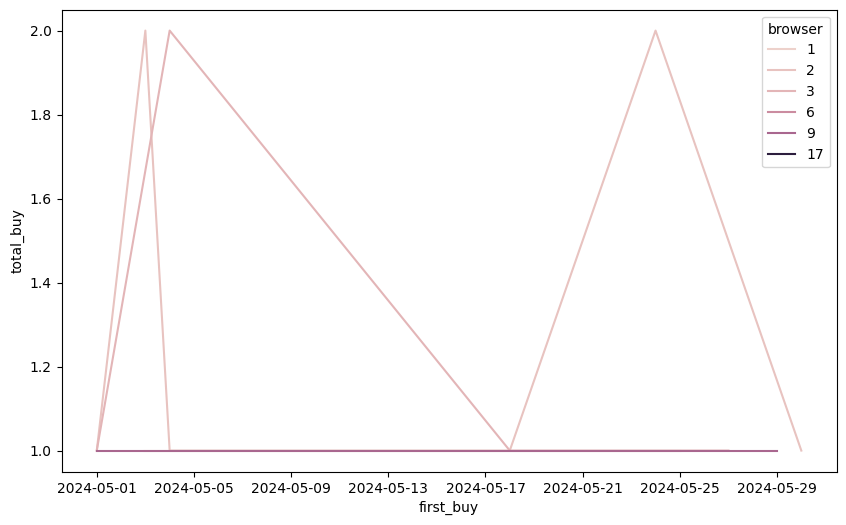

2024-05 - На уровне значимости 0.05 нет значимых различий между группами.


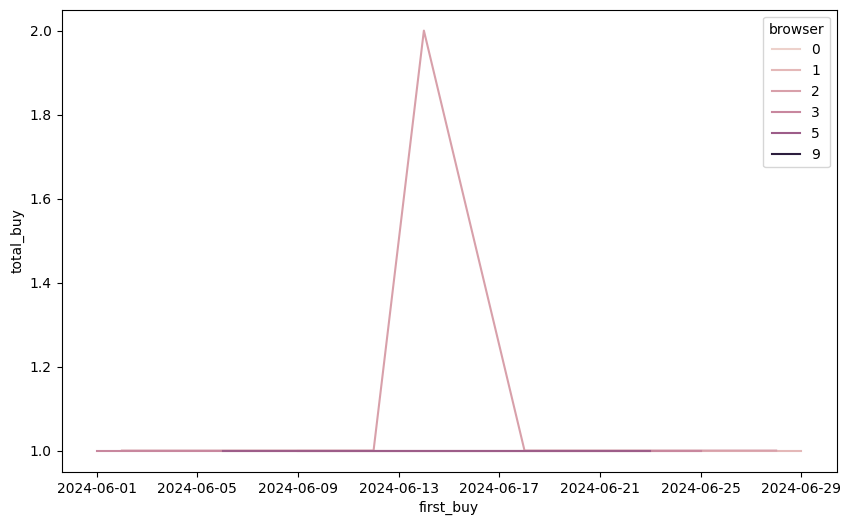

2024-06 - На уровне значимости 0.05 нет значимых различий между группами.


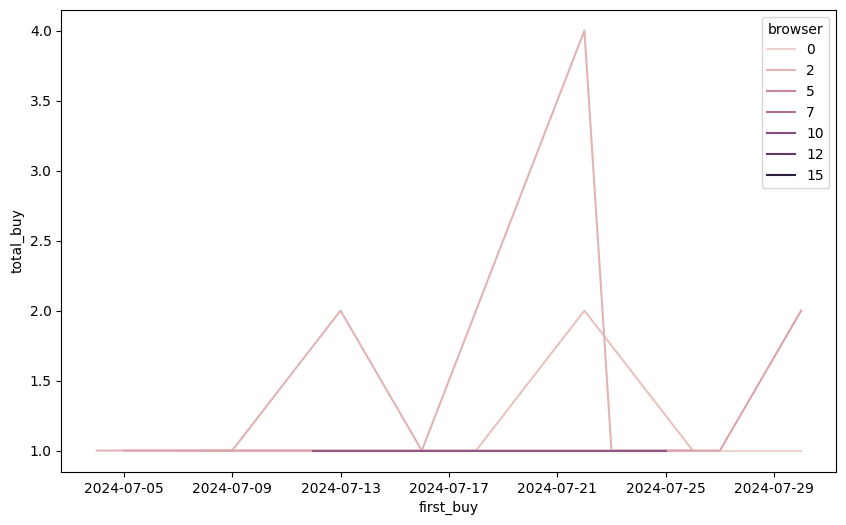

2024-07 - На уровне значимости 0.05 нет значимых различий между группами.


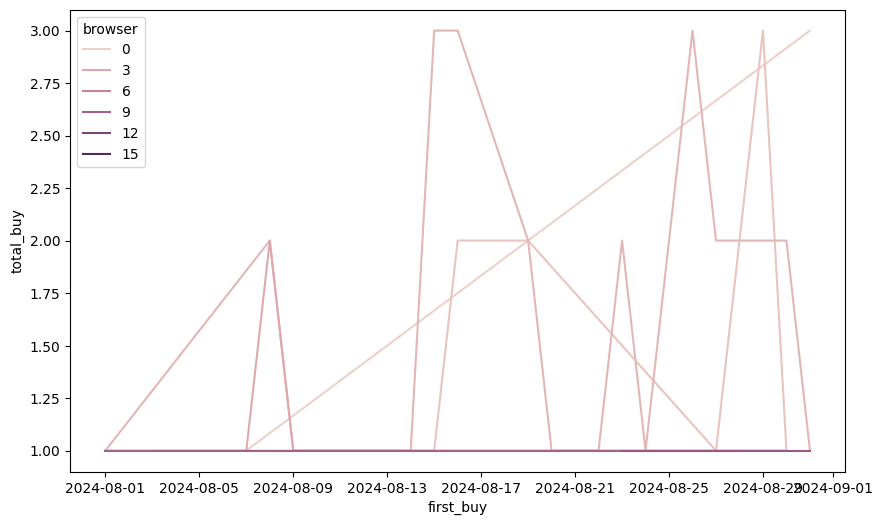

2024-08 - На уровне значимости 0.05 нет значимых различий между группами.


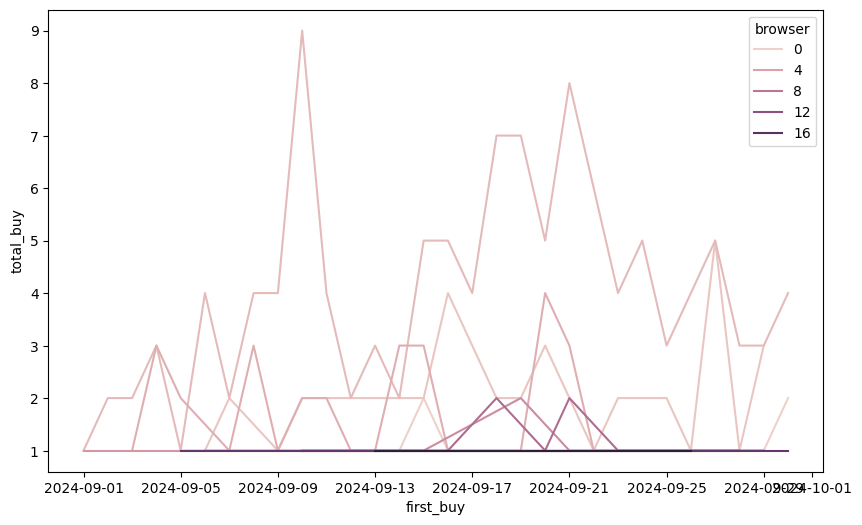

2024-09 - На уровне значимости 0.05 есть значимые различия между группами.


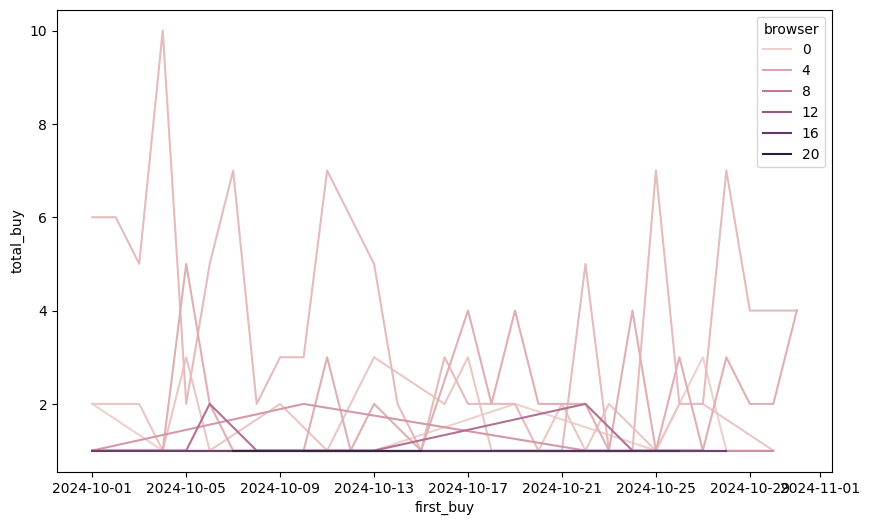

2024-10 - На уровне значимости 0.05 есть значимые различия между группами.


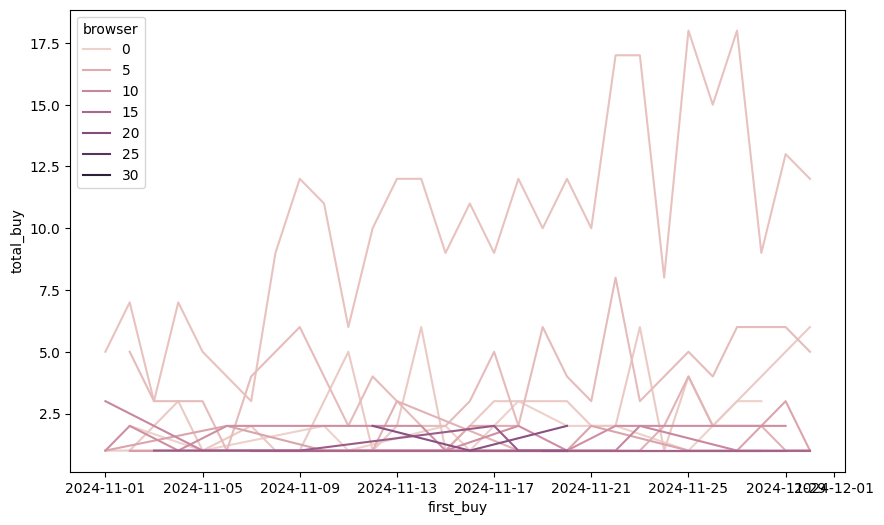

2024-11 - На уровне значимости 0.05 есть значимые различия между группами.


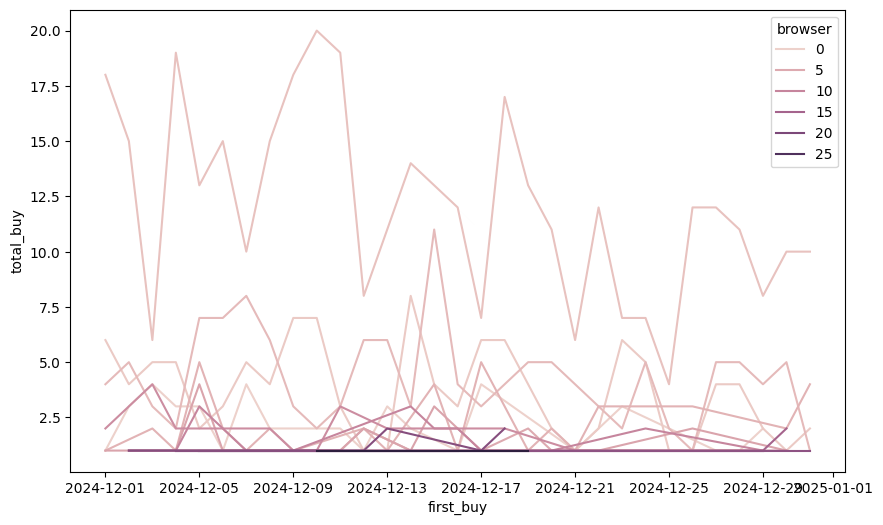

2024-12 - На уровне значимости 0.05 есть значимые различия между группами.


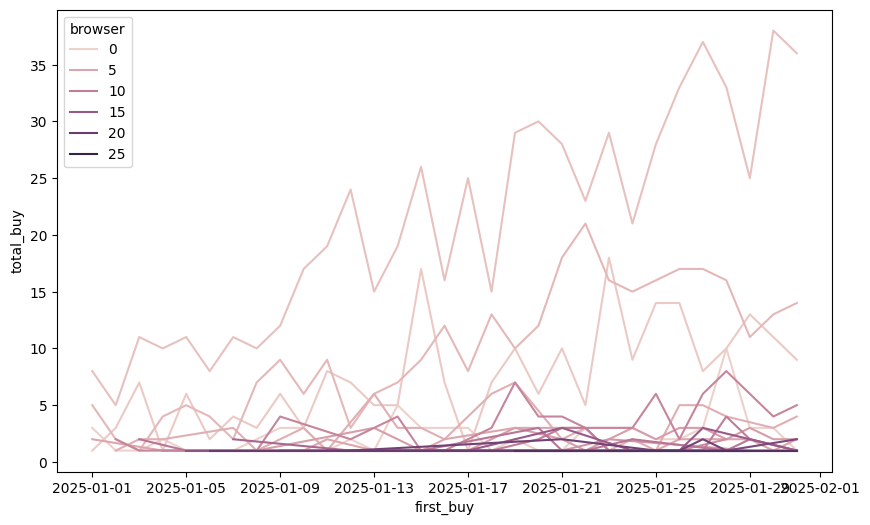

2025-01 - На уровне значимости 0.05 есть значимые различия между группами.


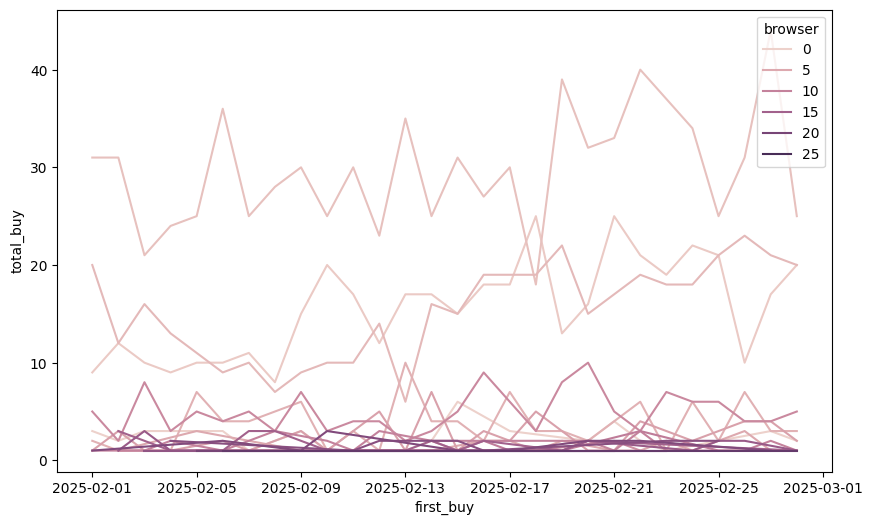

2025-02 - На уровне значимости 0.05 есть значимые различия между группами.


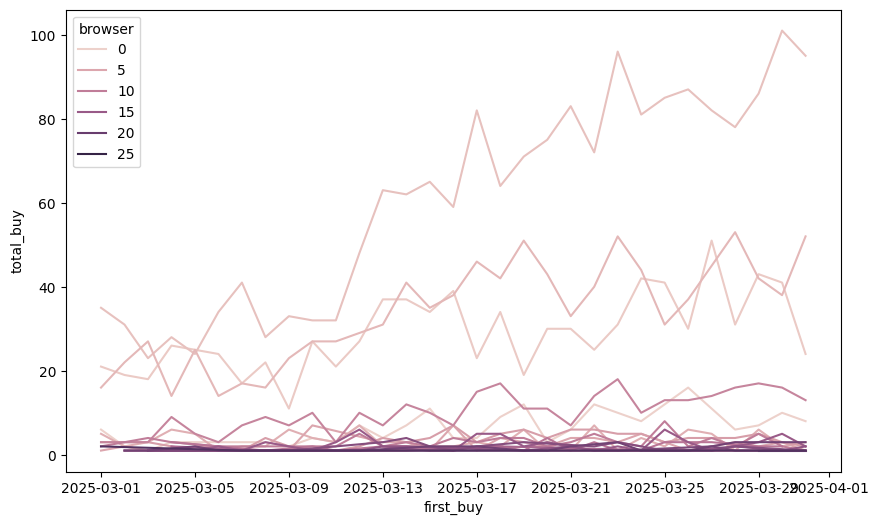

2025-03 - На уровне значимости 0.05 есть значимые различия между группами.


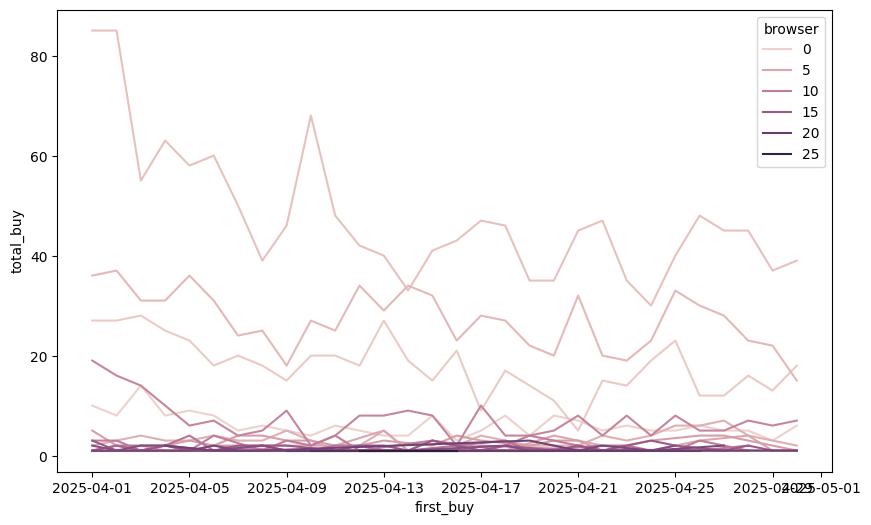

2025-04 - На уровне значимости 0.05 есть значимые различия между группами.


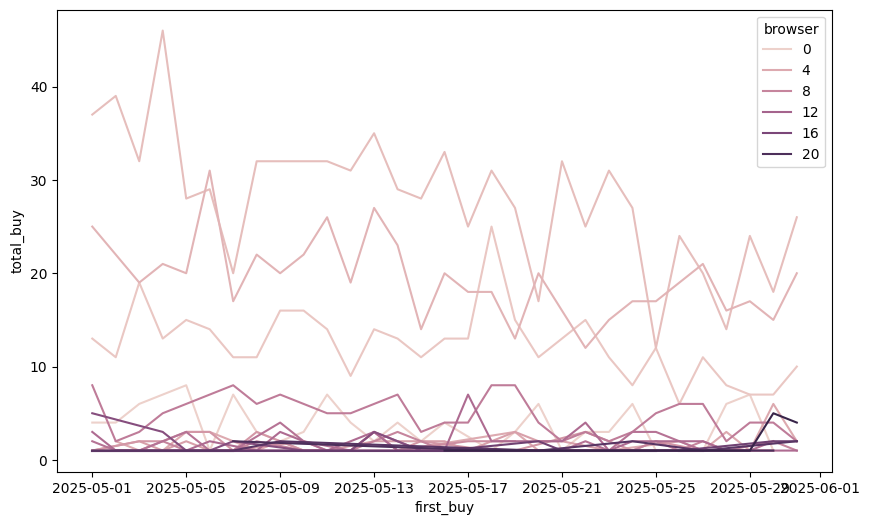

2025-05 - На уровне значимости 0.05 есть значимые различия между группами.


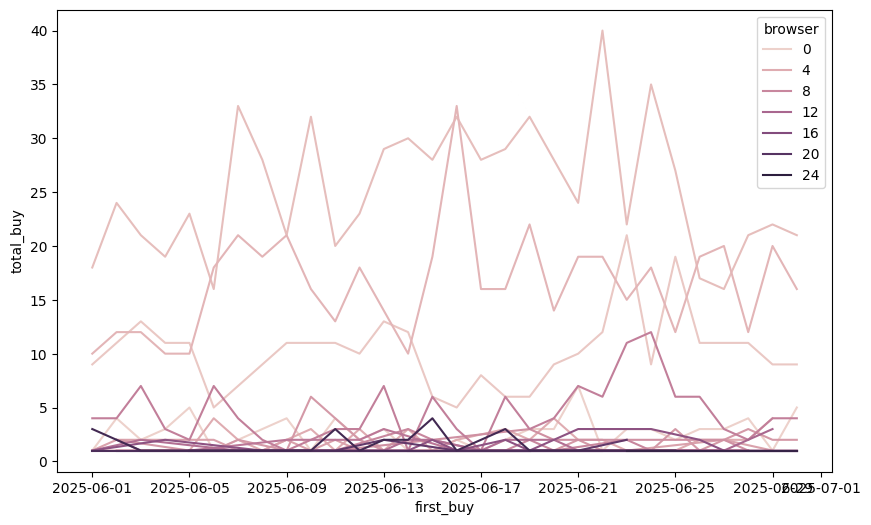

2025-06 - На уровне значимости 0.05 есть значимые различия между группами.


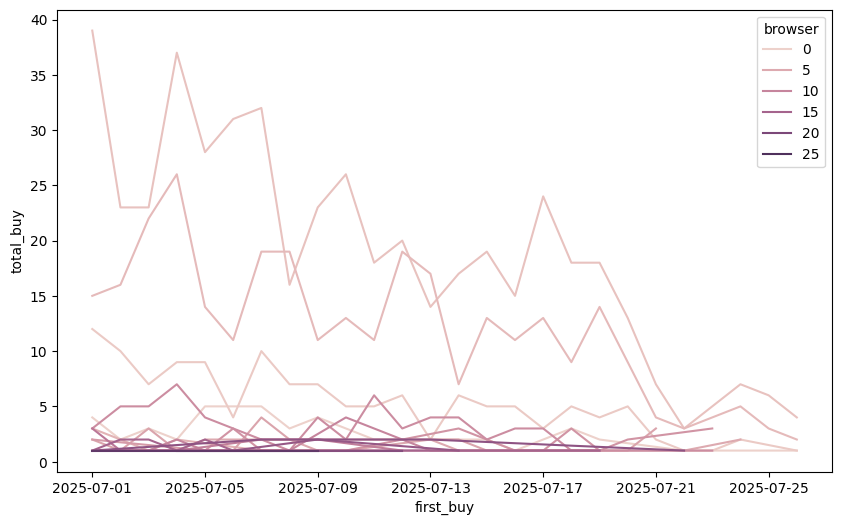

2025-07 - На уровне значимости 0.05 есть значимые различия между группами.


In [324]:
for m in months_array:
    df_browsers_m = df_month(df_browsers, m).reset_index()
    if len(df_browsers_m) > 1:
        plt.figure(figsize=(10, 6))
        sns.lineplot(data=df_browsers_m, x="first_buy", y="total_buy", hue="browser",markers=True, dashes=False)
        
        plt.show()
        plt.close()
        df_browsers_s = df_browsers_array(df_browsers_m)
        if len(df_browsers_s) > 1:
            try:
                print(f'{m} - {statistic(df_browsers_s)}')
            except ValueError:
                pass

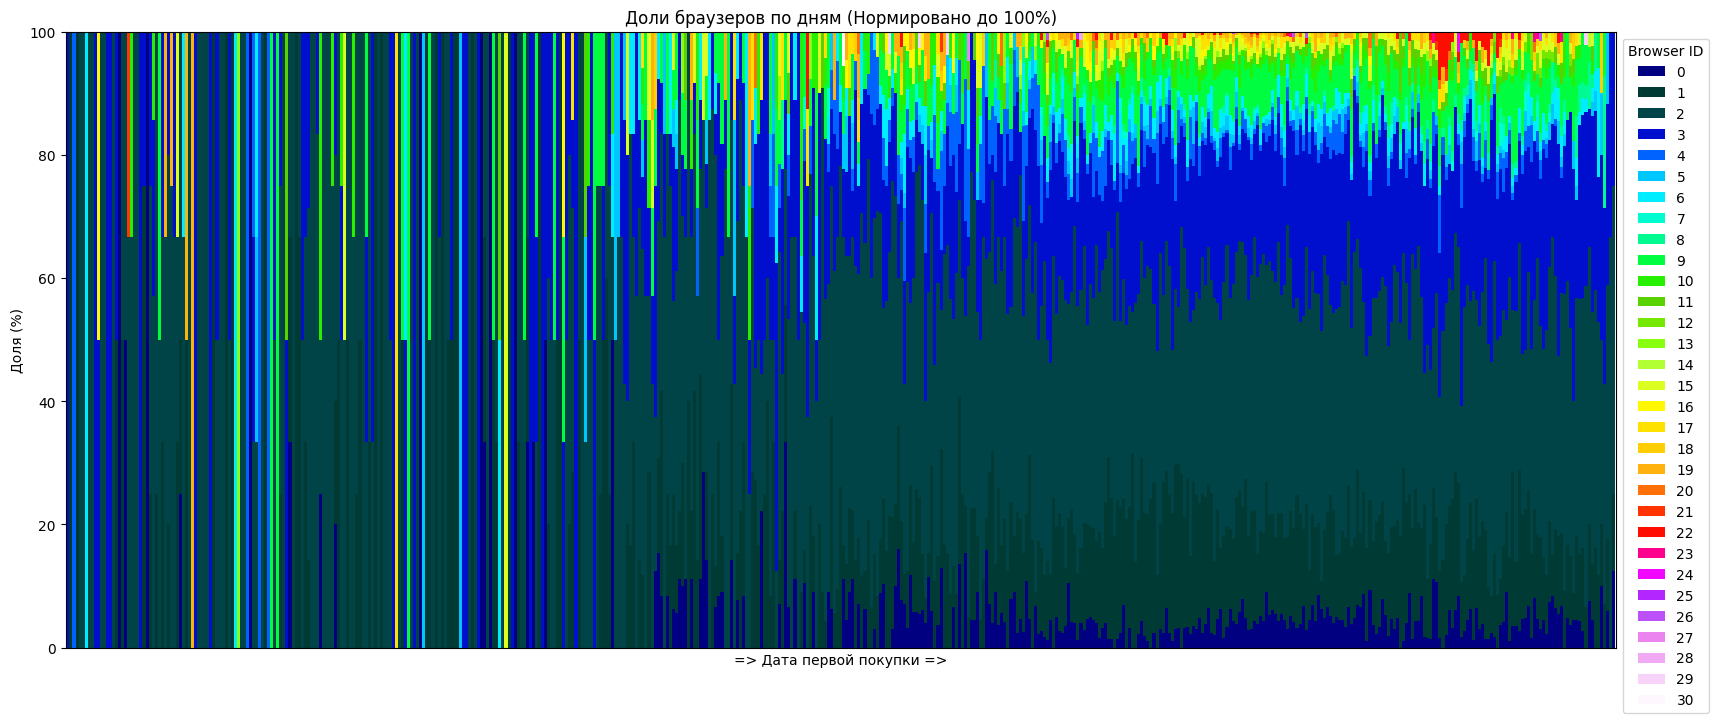

In [134]:
# Для этого построим нормализованный график предпочтений пользователей по браузерам, отсортировав по дате первой покупки.

raw_counts = (
    df_enriched.groupby([df_enriched["first_buy"].dt.date, "browser"])
    .size()
    .unstack(fill_value=0)
)

normalized_df = raw_counts.div(raw_counts.sum(axis=1), axis=0) * 100

ax = normalized_df.plot(
    kind="bar",
    stacked=True,
    title="Доли браузеров по дням (Нормировано до 100%)",
    figsize=(20, 8),
    cmap="gist_ncar",
    width=1,
)

plt.xticks([])
plt.xlabel("=> Дата первой покупки =>")
plt.ylabel("Доля (%)")
plt.ylim(0, 100)


plt.legend(title="Browser ID", bbox_to_anchor=(1, 1), loc="upper left")
plt.show()


Нужно дополнительно построить отдельно для пользователей с возвратами.


### Гипотеза №4 и 5 "Дружно все покупаем!", "Дружно все возвращаем!"
_Аномальные всплески покупок/возвратов за весь период анализа._  

На выдвижение данной гипотезы меня натолкнула идея построения графика покупок/возвратов относительно даты первого логина.    
Этот график не покажет реальные даты всех покупок, так как общая сумма каждого клиента будет приложена к дате его первого логина, но может показать клиентов, кто внёс большой вклад, с привязкой к данной дате.

###Переформулируем гипотезу в формате H₀H₁:
H₀: Аномальные всплески количества покупок (возвратов) за анализируемый период не коррелируют с какими-либо внешними факторами (например, с датами праздников, рекламными акциями).

H₁: Аномальные всплески количества покупок (возвратов) статистически значимо связаны с определенными внешними факторами (например, приходятся на периоды праздников или запуска маркетинговых кампаний).

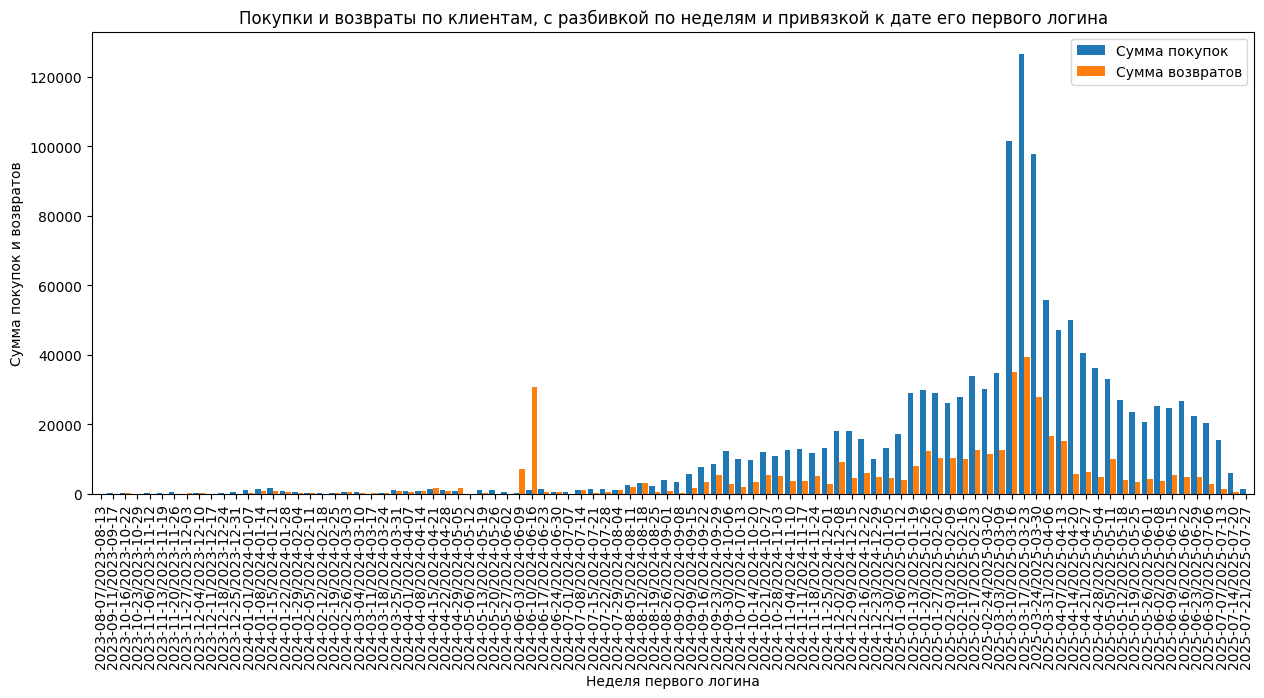

In [18]:
df_enriched["period"] = df_enriched["first_login"].dt.to_period("W")

(
    df_enriched.groupby("period")[["total_buy", "total_return"]]
    .sum()
    .plot(
        kind="bar",
        title="Покупки и возвраты по клиентам, с разбивкой по неделям и привязкой к дате его первого логина",
        figsize=(15, 6),
        width=0.9,
    )
)
plt.legend(["Сумма покупок", "Сумма возвратов"])
plt.xlabel("Неделя первого логина")
plt.ylabel("Сумма покупок и возвратов")
plt.show()


По данному графику видим аномалию в март-апреле 2025. Она коррелирует с гипотезой №1.    
Для анализа потребуется искать причины аномальной активности данных пользователей и корреляцию с гипотезой №1.